In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,classification_report
import os,re
import warnings
warnings.filterwarnings('ignore')
import nltk 
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import tensorflow as tf
from tqdm import tqdm, trange
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel

In [2]:
rcv1_train = pd.read_csv("rcv1_train_data_formatted.csv")
rcv1_test=pd.read_csv("rcv1_test_data_formatted.csv")

In [3]:
rcv1_train.head()

,id,date,newsitem,C11,C12,C13,C14,C15,C151,C1511,...,M11,M12,M13,M131,M132,M14,M141,M142,M143,MCAT
0,2286,1996-08-20,Emerging evidence that Mexico's economy was ba...,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1,2287,1996-08-20,Chrysler Corp. Tuesday announced $380 million ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2288,1996-08-20,CompuServe Corp. Tuesday reported a surprising...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2289,1996-08-20,CompuServe Corp. Tuesday reported a surprising...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2290,1996-08-20,If dining at Planet Hollywood made you feel li...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#number of classes
cols = rcv1_train.columns
label_cols = list(cols[3:106])
print(label_cols)
print(len(label_cols))

#converting train data classes into one hot label list
rcv1_train['one_hot_labels'] = list(rcv1_train[label_cols].values)
rcv1_test['one_hot_labels'] = list(rcv1_test[label_cols].values)

['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16', 'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182', 'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313', 'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11', 'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142', 'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313', 'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT', 'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157', 'G158', 'G159', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT', 'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL', 'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA', 'GWELF', 'M11', 'M12', 'M13', 'M131', 'M132', 'M14', 'M141', 'M142', 'M143', 'MCAT']
103


In [5]:
#the path that we will save best weights in 
model_path = "C:\\Users\\VR-LAB\\RCV1-v2_bert_classification_2.pt"

In [6]:
#the path that have the best weights from the previous trained model and will use them in this new training model 
Model_Path = "C:\\Users\\VR-LAB\\RCV1-v2_bert_classification_1.pt"

In [7]:
import re
#preprocess step
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', str(sen))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', str(sentence))

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', str(sentence))

    return sentence

In [8]:
# cleaning train data 
rcv1_train.loc[:,"newsitem"] = rcv1_train.newsitem.apply(lambda x: preprocess_text(x))
# cleaning test data 
rcv1_test.loc[:,"newsitem"] = rcv1_test.newsitem.apply(lambda x: preprocess_text(x))

labels = list(rcv1_train['one_hot_labels'].values)
newsitem = list(rcv1_train['newsitem'].values)

In [9]:
print('Null values: ', rcv1_train.isnull().values.any())
# print(rcv1_train.isnull().sum())

Null values:  False


In [10]:
print('average train sentence length: ', rcv1_train.newsitem.str.split().str.len().mean())
print('stdev train sentence length: ', rcv1_train.newsitem.str.split().str.len().std())

average train sentence length:  204.10229383558686
stdev train sentence length:  189.21434973921873


In [11]:
print('average test sentence length: ', rcv1_test.newsitem.str.split().str.len().mean())
print('stdev test sentence length: ', rcv1_test.newsitem.str.split().str.len().std())

average test sentence length:  209.47152886664577
stdev test sentence length:  195.82496640697397


In [12]:
#initalise max length , bert tokenizer and encoding train data
#less length in order to avoid memory error
max_length = 400
rcv1_train = rcv1_train.reset_index(drop=True)
# Select a batch size for training. For fine-tuning with Bert, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(newsitem,max_length=max_length,pad_to_max_length=True,truncation=True)

In [13]:
# loading necessary encoded values 
input_ids = encodings['input_ids'] 
token_type_ids = encodings['token_type_ids'] 
attention_masks = encodings['attention_mask']

In [14]:
# splitting data into training and validation
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels,
token_type_ids,attention_masks, random_state=200, test_size=0.20)

In [15]:
# converting all numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [16]:
# creating data loader and loading data into it using random sampler
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [18]:
# saving data loaders
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [19]:
device =  torch.device('cpu')

In [20]:
# loading pretrained BERT model
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(label_cols))
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [21]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [22]:
# initialising optimizer
from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [23]:
model.load_state_dict(torch.load(Model_Path))

<All keys matched successfully>

In [24]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [25]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=5, path=model_path, verbose=True)

# Training and Validation


In [27]:
val_acc_list = []
# Store our loss and accuracy for plotting
train_loss_set = []
valid_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs =50

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # set model to training mode 
    model.train()
    
    # Tracking variables of traning
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
    
     # Tracking variables of validation
    vl_loss = 0 #running loss
    nb_vl_examples, nb_vl_steps = 0, 0

    # train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        # clearing the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(b_input_ids, b_input_mask ,b_token_types)
        logits = outputs
        loss_func = BCEWithLogitsLoss()
        # converting logits and labels to appropriate shape 
        loss = loss_func(logits.view(-1,len(label_cols)),b_labels.type_as(logits).view(-1,len(label_cols))) #convert labels to float for calculation
        train_loss_set.append(loss.item())    


        # backward pass
        loss.backward()
        # update parameters and take a step using the computed gradient
        optimizer.step()
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    #################################################################
    #validation 
    
    # set model to evaluation mode
    model.eval()
    
    # variables to gather outputs
    logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]


    # predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch) 
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        with torch.no_grad():
            # forward pass
            outs = model(b_input_ids, b_input_mask ,b_token_types)
            # Calculate Validation Loss
            logits_val = outs
            
            loss_func_val = BCEWithLogitsLoss() 
            loss_val = loss_func_val(logits_val.view(-1,len(label_cols)),b_labels.type_as(logits_val).view(-1,len(label_cols))) #convert labels to float for calculation
            valid_loss_set.append(loss_val.item())
            
            vl_loss += loss_val.item()
            nb_vl_examples += b_input_ids.size(0)
            nb_vl_steps += 1

            b_logit_pred = outs
            pred_label = torch.sigmoid(b_logit_pred)

            # converting tensors to numpy arrays
            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            b_labels = b_labels.to('cpu').numpy()
            
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
        
    print("Validation loss: {}".format(vl_loss/nb_vl_steps))
    
    # flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    
    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(vl_loss/nb_vl_steps, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

Train loss: 0.00751430389172975
Validation loss: 0.026764834017075342
F1 Validation Accuracy:  87.28769943386516
Flat Validation Accuracy:  64.70842332613391
Validation loss decreased (inf --> 0.026765).  Saving model ...


Epoch:   2%|█▎                                                                 | 1/50 [7:17:00<356:53:14, 26220.30s/it]

Train loss: 0.006881657998288285


Epoch:   4%|██▋                                                               | 2/50 [14:37:07<351:04:24, 26330.50s/it]

Validation loss: 0.027177684201762593
F1 Validation Accuracy:  87.3232620043558
Flat Validation Accuracy:  64.94600431965442
EarlyStopping counter: 1 out of 5
Train loss: 0.006397341341439744


Epoch:   6%|███▉                                                              | 3/50 [21:58:05<344:31:09, 26388.70s/it]

Validation loss: 0.027442002508403927
F1 Validation Accuracy:  87.30318026092675
Flat Validation Accuracy:  64.38444924406048
EarlyStopping counter: 2 out of 5
Train loss: 0.006005308122755332


Epoch:   8%|█████▎                                                            | 4/50 [29:17:17<337:00:07, 26374.08s/it]

Validation loss: 0.028345857840031387
F1 Validation Accuracy:  86.97129267878375
Flat Validation Accuracy:  63.498920086393085
EarlyStopping counter: 3 out of 5
Train loss: 0.005545467602343191


Epoch:  10%|██████▌                                                           | 5/50 [36:38:00<329:59:04, 26398.76s/it]

Validation loss: 0.027883314296346287
F1 Validation Accuracy:  87.29648378711178
Flat Validation Accuracy:  64.44924406047517
EarlyStopping counter: 4 out of 5
Train loss: 0.005213994575850987


Epoch:  10%|██████▌                                                           | 5/50 [44:00:11<396:01:46, 31682.38s/it]

Validation loss: 0.02841587146294528
F1 Validation Accuracy:  87.39300937766413
Flat Validation Accuracy:  64.90280777537797
EarlyStopping counter: 5 out of 5
Early stopping


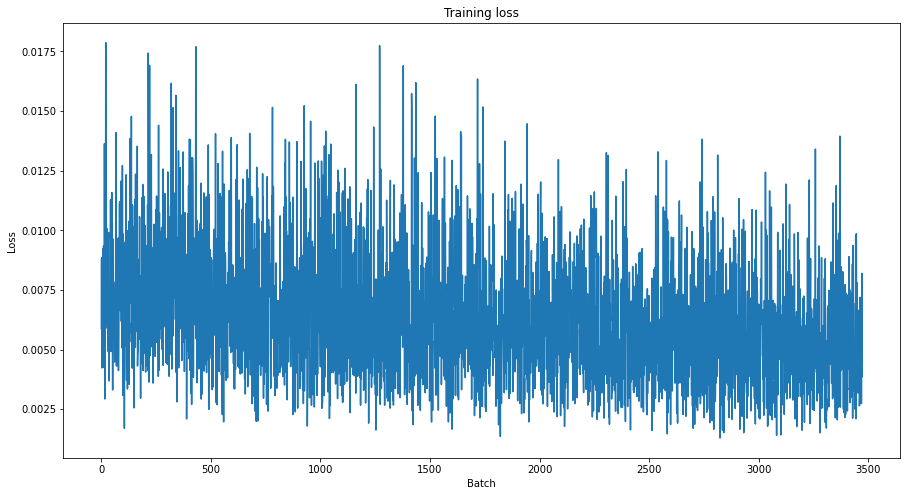

In [28]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [29]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
# Gathering input data
test_labels = list(rcv1_test['one_hot_labels'].values)
rcv1_test['newsitem'] = rcv1_test['newsitem'].astype(str)
test_newsitems = list(rcv1_test.newsitem.values)

In [31]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_newsitems,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [32]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [33]:
# testing 

# put model in evaluation mode 
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from test dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
        # forward pass
        outs = model(b_input_ids, b_input_mask ,b_token_types)
        b_logit_pred = outs
        pred_label = torch.sigmoid(b_logit_pred)

        # converting into numpy arrays 
        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()
        
    # appending output variables 
    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    pred_labels.append(pred_label)  
    true_labels.append(b_labels) 
    
# flatten output variables
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
 
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [34]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=label_cols)
pickle.dump(clf_report, open('classification_report_2.txt','wb'))
print(clf_report)

Test F1 Accuracy:  0.8564778744914592
Test Flat Accuracy:  0.6162480080382456 

              precision    recall  f1-score   support

         C11       0.62      0.52      0.56     23651
         C12       0.81      0.70      0.75     11563
         C13       0.64      0.61      0.62     36463
         C14       0.64      0.65      0.64      7250
         C15       0.94      0.94      0.94    147606
        C151       0.95      0.91      0.93     79524
       C1511       0.85      0.67      0.75     22812
        C152       0.85      0.88      0.86     71162
         C16       1.00      0.00      0.00      1871
         C17       0.85      0.79      0.82     40983
        C171       0.86      0.72      0.79     17876
        C172       0.89      0.79      0.83     11202
        C173       0.81      0.51      0.62      2560
        C174       0.95      0.91      0.93      5625
         C18       0.86      0.88      0.87     51355
        C181       0.84      0.84      0.84     42169
 

In [35]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
pickle.dump(clf_report_optimized, open('classification_report_optimized_2.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.52
Test F1 Accuracy:  0.8565312061722438
Test Flat Accuracy:  0.6165078430494134 

              precision    recall  f1-score   support

         C11       0.63      0.51      0.56     23651
         C12       0.81      0.70      0.75     11563
         C13       0.64      0.60      0.62     36463
         C14       0.65      0.64      0.64      7250
         C15       0.94      0.94      0.94    147606
        C151       0.95      0.91      0.93     79524
       C1511       0.85      0.66      0.75     22812
        C152       0.85      0.88      0.86     71162
         C16       1.00      0.00      0.00      1871
         C17       0.86      0.79      0.82     40983
        C171       0.86      0.72      0.78     17876
        C172       0.89      0.79      0.83     11202
        C173       0.81      0.50      0.62      2560
        C174       0.95      0.90      0.93      5625
         C18       0.86      0.88      0.87     51355
        C181       0.84      0.84